## Experiment 1:
Experiment 1: SVM using the 20 sampled data points without enhancements

In [1]:
# All modules:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.spatial import distance
import math
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering
import random

## Functions:

In [2]:
# Purpose of function is to classify only k nearest points to the training dataset:
def knnclassify_nearestk2(dataset, training, labels, k, fault):
    closest_k = []
    # run through the training data points, and find k closest neighbors to each training point
    for i in range(len(training)):
        distances = []
        for u in range(len(dataset)):
            if u not in dataset:
                # Measure distances of all points in the dataset from training[i]
                # Distance metric is subject to change
                distances.append(distance.euclidean(training.iloc[i,:],dataset.iloc[u,0:24]))
            else:
                continue
        # Select the indices of the closest k data points to the training[i]
        distances_ = sorted(range(len(distances)), key = lambda sub: distances[sub])[:k]
        # Label the closest points with the same label as training[i]
        dataset.loc[distances_,fault] = labels.iloc[i][0]
        # Save indices of closest points
        closest_k.append(distances_)
    closest_k_p = list(itertools.chain.from_iterable(closest_k))
    # Select new training dataset to include closest points to all training examples
    return dataset.iloc[closest_k_p,:]

In [3]:
# This function is for sampling evenly from each class (binary classes 0; No Fault and 1, Fault) for each fault:
def sampling(new_df, fault, num_sam, corr_list):
    # Try Sampling unevenly:
#     sample = new_df.groupby(fault).apply(lambda x: x.sample(num_sam))
    sample = new_df.sample(n = num_sam)
    # Drop features
    x_train = sample.drop(['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A'], axis = 1)
    x_train = x_train.loc[:,corr_list]
    # Select only Lavels
    y_train = sample.loc[:,['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A']]
    y_train = y_train.loc[:,~y_train.columns.duplicated()]
    # Save indices of the sampled data points:
#     inds = [r[1] for r in sample.index]
    inds = sample.index.to_list()
    return sample, x_train, y_train, inds

In [4]:
# This function takes the dataframe, x_train, y_train, and the indices of the training data points so that
# We can split the data into x_train, y_train, x_test, y_test, and use the SVM model for training an evaluation:
def SVM_model(fault, new_df, x_train, y_train, inds, df_corr_list):
    
    x_test = df_corr_list.iloc[:,0:24]
    y_test = new_df.loc[:,['No Fault', 'Evaporator Fault', 'Condenser Fault' ,'Undercharged B', 'Overcharged A']]

    x_test = x_test.drop(inds, axis= 0)
    y_test = y_test.drop(inds, axis= 0)

    y_train = y_train.loc[:,fault]
    y_test = y_test.loc[:,fault]

    model = svm.SVC(kernel='linear', C = 1.22, class_weight = 'balanced')# Linear Kernel
    # scaler = preprocessing.StandardScaler()
    # max_abs_scaler = preprocessing.MaxAbsScaler()
    quantile_transformer = preprocessing.QuantileTransformer(n_quantiles = x_train.shape[0], random_state=0)
    # normalizer = preprocessing.Normalizer()
    # pt = preprocessing.PowerTransformer('yeo-johnson', standardize=False)

    x_train = quantile_transformer.fit_transform(x_train)
    x_test = quantile_transformer.transform(x_test)
    
    model.fit(x_train, y_train)
     # evaluate model and report performance
    pred_svm = model.predict(x_test)
    
    acc = accuracy_score(y_test, pred_svm)
    
    return acc, x_train, y_train, x_test, y_test
    

In [5]:
# This function is for trying various number of neighbors when implemeneting Dr. Raj's k-NN labeling method:
vals = [1,5,10,15,20]
def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault, inds):
    acc = []
    train = []
    for i in vals:
        # Make a new training set by calling the function: knnclassify_nearestk2
        new_training3 = knnclassify_nearestk2(new_df, x_train, y_train, i, fault)
        # Join the sampled data set with the new training dataset we have.
        new_training_2 = pd.concat([sample, new_training3], axis = 0)
        # Remove repeated datapoints
        new_train3 = list(set(new_training3.index)) + inds 
        # Extract dataset with only features
        new_df_corr = new_df.loc[:,corr_list[0:24]]
        # New x_train, and y_train by using the indices of all the training examples and selecting them
        x_trainrj3 = new_df_corr.iloc[new_train3,:]
        y_trainrj3 = new_df.loc[new_train3, fault]
        # New x_test, and y_test by using the indices of all the training examples and droping them
        x_testrj3 = new_df_corr.drop(new_df_corr.iloc[new_train3,:].index)
        y_testrj3 = new_df.drop(new_df.loc[new_train3,fault].index)
        # Select only the column containg the fault we are working with
        y_testrj3 = y_testrj3.loc[:,fault]
        # SVM model:
        model = svm.SVC(kernel='poly', C = 1.22, degree = 5)# Linear Kernel
        # scaler = preprocessing.StandardScaler()
        # max_abs_scaler = preprocessing.MaxAbsScaler()
        quantile_transformer = preprocessing.QuantileTransformer(n_quantiles = x_trainrj3.shape[0], random_state=0)
        # # normalizer = preprocessing.Normalizer()
        # # pt = preprocessing.PowerTransformer('yeo-johnson', standardize=False)
        x_trainrj3 = quantile_transformer.fit_transform(x_trainrj3)
        x_testrj3 = quantile_transformer.transform(x_testrj3)
        
        # evaluate model and report performance
        model.fit(x_trainrj3, y_trainrj3)
        pred_svmrj3 = model.predict(x_testrj3)
        acc.append(accuracy_score(y_testrj3, pred_svmrj3))
        train.append(len(new_training_2))
        
    plot1 = plt.plot(vals, acc,'bo')
    plt.plot(vals, acc, 'r')
    plt.xlabel('# of K')
    plt.ylabel('Accuracy (%)')
    plt.title('# of K vs. Accuracy (k-NN)')
#         plot2 = plt.plot(train, acc,'ko')
#         plt.plot(train, acc, 'g')
#         plt.xlabel('Training set size')
#         plt.ylabel('Accuracy (%)')
#         plt.title('Training set size vs. Accuracy')
    max_ind = acc.index(max(acc))
    k_max = vals[max_ind]
    print('The highest accuracy is:', max(acc), 'using k = ', k_max, 'neighbors for labeling.')
    return plot1

## Labeling:

In [6]:
# Applying this function to all the rows, FAN, COMP.A and COMP.B
# classifying system as working or not working --> 0 = not working, and 1 = working
# This function is not used here:
def labels(row):
    if row['FAN'] > 0 and (row['COMP.A'] > 0 or row['COMP.B'] > 0):
#         row['LABELS'] = 1
        row['System Status'] = 1
    elif row['FAN'] <= 0 and (row['COMP.A'] <= 0 or row['COMP.B'] <= 0):
#         row['LABELS'] = 0
        row['System Status'] = 0

    if row['FI.REF.A'] < -0.2:
        row['Underchargd A'] = 1
        
    # Overcharged A    
    elif row['FI.REF.A'] > 0.2:
        row['Overcharged A'] = 1
        
    # System Off
    #elif row['COMP.A'] == 0 or row['COMP.B'] == 0 or row['System Status'] == 0:
   #     row['System Status'] = 0
        
    # Undercharged B    
    if row['FI.REF.B'] < -0.2:
        row['Undercharged B'] = 1
        
    # Overcharged B   
    elif row['FI.REF.B'] > 0.2:
        row['Overcharged B'] = 1
        
    # For Condensor faults
    if row['FI.COND'] < -0.4:
        row['Condenser Fault'] = 1 # fault
        
    # For Evaporator faults  
    if row['FI.EVAP'] < -0.4:
        row['Evaporator Fault'] = 1
        
#     else:
#         # No Fault
#         row['No Fault'] = 1
        
    return row

# df_class = df.apply(temp, axis=1)

# Binary Classification:

In [7]:
# Upload dataset containg features and labels
# new_df = pd.read_csv('New Data without System Off (binary classification).csv').drop('Unnamed: 0', axis = 1)
new_df = pd.read_csv('New Dataset with one-hot (New FIs).csv')
# Upload feature list
import pickle
with open('column_names.pkl', 'rb') as f:
    unpickler = pickle.Unpickler(f)
    corr_list = unpickler.load()
# Dataset with only the features:
new_df_corr = new_df.loc[:,corr_list]

In [8]:
new_df.loc[:,'No Fault'].value_counts()

0.0    3163
1.0     173
Name: No Fault, dtype: int64

# Evaporator Fault:

In [9]:
sample_ef = sampling(new_df, 'Evaporator Fault', 30, corr_list)
# Refer to function to see what it returns 

## SVM:

In [10]:
acc_ef = SVM_model('Evaporator Fault', new_df, sample_ef[1], sample_ef[2], sample_ef[3], new_df_corr)
acc_ef[0]

0.9748941318814277

## k-NN + SVM:

The highest accuracy is: 0.9674475205354427 using k =  20 neighbors for labeling.


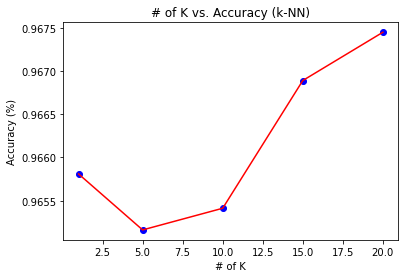

In [11]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_ef[1])
y_train = pd.DataFrame(acc_ef[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_ef[0], corr_list, 'Evaporator Fault', sample_ef[3])
# Refer to function to see what it returns 

# No Fault:

In [15]:
sample_nf = sampling(new_df, 'No Fault', 30, corr_list)

## SVM:

In [16]:
acc_nf = SVM_model('No Fault', new_df, sample_nf[1], sample_nf[2], sample_nf[3], new_df_corr)
acc_nf[0]

0.8064125831820932

## k-NN +SVM:

The highest accuracy is: 0.9176007270524084 using k =  5 neighbors for labeling.


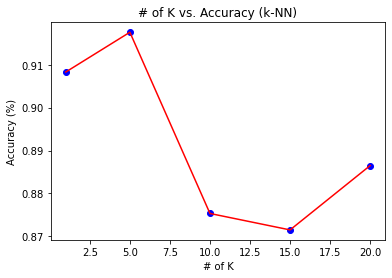

In [17]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_nf[1])
y_train = pd.DataFrame(acc_nf[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_nf[0], corr_list, 'No Fault', sample_nf[3])

# Condenser Fault:

In [18]:
sample_cf = sampling(new_df, 'Condenser Fault', 30, corr_list)

## SVM:

In [19]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_cf = SVM_model('Condenser Fault', new_df, sample_cf[1], sample_cf[2], sample_cf[3], new_df_corr)
acc_cf[0]

0.9385964912280702

## k-NN + SVM:

The highest accuracy is: 0.9391093607997576 using k =  5 neighbors for labeling.


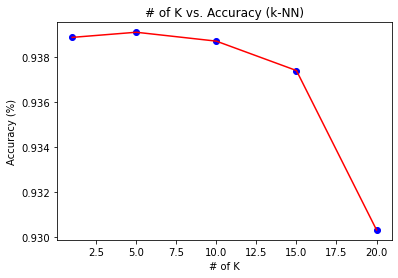

In [20]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_cf[1])
y_train = pd.DataFrame(acc_cf[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_cf[0], corr_list, 'Condenser Fault', sample_cf[3])

# Undercharged B:

In [21]:
sample_UB = sampling(new_df, 'Undercharged B', 30, corr_list)
# [0] = sampled dataset; [1] = x_train; [2] = y_train, [3] = inds

## SVM:

In [22]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_UB = SVM_model('Undercharged B', new_df, sample_UB[1], sample_UB[2], sample_UB[3], new_df_corr)
acc_UB[0]

0.999395039322444

## k-NN + SVM:

The highest accuracy is: 0.9975764919721296 using k =  5 neighbors for labeling.


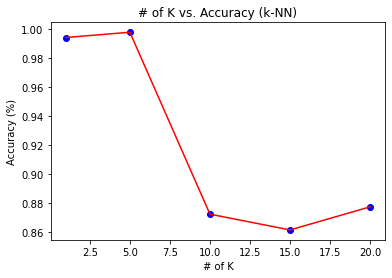

In [23]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_UB[1])
y_train = pd.DataFrame(acc_UB[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_UB[0], corr_list, 'Undercharged B', sample_UB[3])

# Overcharged A:

In [24]:
sample_OA = sampling(new_df, 'Overcharged A', 30, corr_list)
# [0] = sampled dataset; [1] = x_train; [2] = y_train, [3] = inds

## SVM:

In [25]:
# def SVM_model(fault, new_df, x_train, y_train, inds):
acc_OA = SVM_model('Overcharged A', new_df, sample_OA[1], sample_OA[2], sample_OA[3], new_df_corr)
acc_OA[0]

0.9540229885057471

## k-NN + SVM:

The highest accuracy is: 0.9234275296262534 using k =  15 neighbors for labeling.


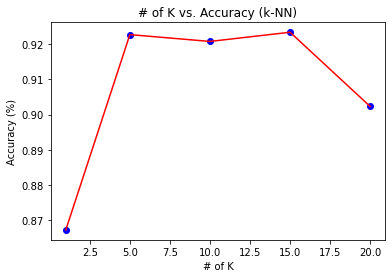

In [26]:
# def plt_knn_alon(vals, new_df, x_train, y_train, sample, corr_list, fault):
x_train = pd.DataFrame(acc_OA[1])
y_train = pd.DataFrame(acc_OA[2])
# x_test = pd.DataFrame(acc_cf[3])
# y_test = pd.DataFrame(acc_cf[4])
plt_knn_alon(vals, new_df, x_train, y_train, sample_OA[0], corr_list, 'Overcharged A', sample_OA[3])